In [5]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [6]:
# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [7]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


tensor(0.2181, dtype=torch.float64)

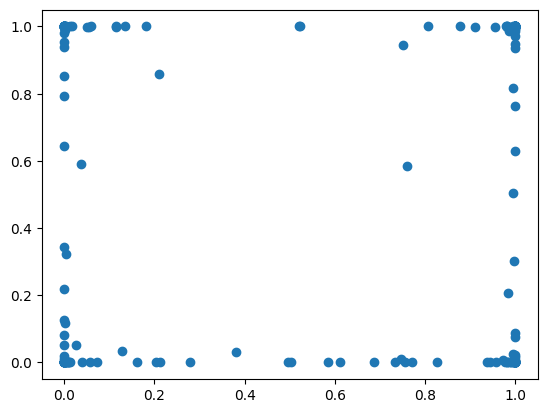

In [8]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x3@beta_3).squeeze().cov()

In [9]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [12]:
################## first step##################

prior=2
# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lr,ga,lambda1= config["lr"], config["ga"], config["lambda1"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        lambda2=0.002
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr": tune.choice([0.6,0.9]),
        "ga": tune.choice([0.2,0.5]),
        "lambda1": tune.choice([0.005,0.01,0.03,0.05])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=50)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,ga,lambda1,lr,iter,total time (s),my_test_BCE_loss
train_model_6b1c6_00000,TERMINATED,10.224.0.12:12775,0.5,0.005,0.6,1,23.9426,1.68514
train_model_6b1c6_00001,TERMINATED,10.224.0.12:13223,0.2,0.05,0.6,1,26.0824,1.27807
train_model_6b1c6_00002,TERMINATED,10.224.0.12:13225,0.2,0.03,0.6,1,25.5541,1.43851
train_model_6b1c6_00003,TERMINATED,10.224.0.12:13227,0.5,0.05,0.9,1,23.8671,0.929117
train_model_6b1c6_00004,TERMINATED,10.224.0.12:13229,0.5,0.005,0.9,1,24.6556,1.52565
train_model_6b1c6_00005,TERMINATED,10.224.0.12:13231,0.5,0.05,0.6,1,25.3089,1.22833
train_model_6b1c6_00006,TERMINATED,10.224.0.12:13233,0.5,0.05,0.9,1,25.5323,0.929117
train_model_6b1c6_00007,TERMINATED,10.224.0.12:13235,0.2,0.01,0.9,1,25.3306,1.55383
train_model_6b1c6_00008,TERMINATED,10.224.0.12:13237,0.5,0.05,0.6,1,25.5473,1.22833
train_model_6b1c6_00009,TERMINATED,10.224.0.12:13239,0.5,0.005,0.6,1,24.0337,1.68514


Result for train_model_6b1c6_00000:
  date: 2022-10-12_15-42-53
  done: false
  experiment_id: cc0d0849c26c4f8cb51837d43c2ae395
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6851385474205016
  node_ip: 10.224.0.12
  pid: 12775
  time_since_restore: 23.94257664680481
  time_this_iter_s: 23.94257664680481
  time_total_s: 23.94257664680481
  timestamp: 1665560573
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6b1c6_00000
  warmup_time: 0.0041468143463134766
  
Result for train_model_6b1c6_00000:
  date: 2022-10-12_15-42-53
  done: true
  experiment_id: cc0d0849c26c4f8cb51837d43c2ae395
  experiment_tag: 0_ga=0.5000,lambda1=0.0050,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6851385474205016
  node_ip: 10.224.0.12
  pid: 12775
  time_since_restore: 23.94257664680481
  time_this_iter_s: 23.94257664680481
  time_total_s: 23.94257664680481
  timestamp: 1665560573
  timesteps_since_restore: 

Result for train_model_6b1c6_00011:
  date: 2022-10-12_15-42-57
  done: false
  experiment_id: 0ef8c192152941ec953f77e1c2f1cc07
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5538307189941407
  node_ip: 10.224.0.12
  pid: 13243
  time_since_restore: 24.332399129867554
  time_this_iter_s: 24.332399129867554
  time_total_s: 24.332399129867554
  timestamp: 1665560577
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6b1c6_00011
  warmup_time: 0.0096282958984375
  
Result for train_model_6b1c6_00011:
  date: 2022-10-12_15-42-57
  done: true
  experiment_id: 0ef8c192152941ec953f77e1c2f1cc07
  experiment_tag: 11_ga=0.2000,lambda1=0.0100,lr=0.9000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5538307189941407
  node_ip: 10.224.0.12
  pid: 13243
  time_since_restore: 24.332399129867554
  time_this_iter_s: 24.332399129867554
  time_total_s: 24.332399129867554
  timestamp: 1665560577
  timesteps_since_resto

Result for train_model_6b1c6_00006:
  date: 2022-10-12_15-42-59
  done: false
  experiment_id: c37064eaeb764015b28442d538e951dc
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 0.9291169226169587
  node_ip: 10.224.0.12
  pid: 13233
  time_since_restore: 25.532339811325073
  time_this_iter_s: 25.532339811325073
  time_total_s: 25.532339811325073
  timestamp: 1665560579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6b1c6_00006
  warmup_time: 0.005266427993774414
  
Result for train_model_6b1c6_00006:
  date: 2022-10-12_15-42-59
  done: true
  experiment_id: c37064eaeb764015b28442d538e951dc
  experiment_tag: 6_ga=0.5000,lambda1=0.0500,lr=0.9000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 0.9291169226169587
  node_ip: 10.224.0.12
  pid: 13233
  time_since_restore: 25.532339811325073
  time_this_iter_s: 25.532339811325073
  time_total_s: 25.532339811325073
  timestamp: 1665560579
  timesteps_since_rest

Result for train_model_6b1c6_00032:
  date: 2022-10-12_15-43-10
  done: false
  experiment_id: cc0d0849c26c4f8cb51837d43c2ae395
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5538307189941407
  node_ip: 10.224.0.12
  pid: 12775
  time_since_restore: 16.8012433052063
  time_this_iter_s: 16.8012433052063
  time_total_s: 16.8012433052063
  timestamp: 1665560590
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6b1c6_00032
  warmup_time: 0.0041468143463134766
  
Result for train_model_6b1c6_00032:
  date: 2022-10-12_15-43-10
  done: true
  experiment_id: cc0d0849c26c4f8cb51837d43c2ae395
  experiment_tag: 32_ga=0.2000,lambda1=0.0100,lr=0.9000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5538307189941407
  node_ip: 10.224.0.12
  pid: 12775
  time_since_restore: 16.8012433052063
  time_this_iter_s: 16.8012433052063
  time_total_s: 16.8012433052063
  timestamp: 1665560590
  timesteps_since_restore: 0
  t

Result for train_model_6b1c6_00049:
  date: 2022-10-12_15-43-14
  done: false
  experiment_id: 25af9dd24d1a468f83d6bae387245cfc
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1797300159931183
  node_ip: 10.224.0.12
  pid: 13235
  time_since_restore: 15.439674139022827
  time_this_iter_s: 15.439674139022827
  time_total_s: 15.439674139022827
  timestamp: 1665560594
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6b1c6_00049
  warmup_time: 0.015176773071289062
  
Result for train_model_6b1c6_00049:
  date: 2022-10-12_15-43-14
  done: true
  experiment_id: 25af9dd24d1a468f83d6bae387245cfc
  experiment_tag: 49_ga=0.5000,lambda1=0.0300,lr=0.9000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1797300159931183
  node_ip: 10.224.0.12
  pid: 13235
  time_since_restore: 15.439674139022827
  time_this_iter_s: 15.439674139022827
  time_total_s: 15.439674139022827
  timestamp: 1665560594
  timesteps_since_res

Result for train_model_6b1c6_00039:
  date: 2022-10-12_15-43-17
  done: false
  experiment_id: 9a8497b78d36425ba57fc5cdbf335a6c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6851385474205016
  node_ip: 10.224.0.12
  pid: 13239
  time_since_restore: 19.88080620765686
  time_this_iter_s: 19.88080620765686
  time_total_s: 19.88080620765686
  timestamp: 1665560597
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6b1c6_00039
  warmup_time: 0.0059356689453125
  
Result for train_model_6b1c6_00039:
  date: 2022-10-12_15-43-17
  done: true
  experiment_id: 9a8497b78d36425ba57fc5cdbf335a6c
  experiment_tag: 39_ga=0.5000,lambda1=0.0050,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6851385474205016
  node_ip: 10.224.0.12
  pid: 13239
  time_since_restore: 19.88080620765686
  time_this_iter_s: 19.88080620765686
  time_total_s: 19.88080620765686
  timestamp: 1665560597
  timesteps_since_restore: 0


2022-10-12 15:43:17,899	INFO tune.py:758 -- Total run time: 50.83 seconds (50.56 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
6b1c6_00000          1.685139         23.942577  True            None   
6b1c6_00001          1.278070         26.082431  True            None   
6b1c6_00002          1.438509         25.554132  True            None   
6b1c6_00003          0.929117         23.867119  True            None   
6b1c6_00004          1.525648         24.655635  True            None   
6b1c6_00005          1.228330         25.308941  True            None   
6b1c6_00006          0.929117         25.532340  True            None   
6b1c6_00007          1.553831         25.330583  True            None   
6b1c6_00008          1.228330         25.547277  True            None   
6b1c6_00009          1.685139         24.033673  True            None   
6b1c6_00010          1.663180         25.518556  True            N

In [13]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 0.9291169226169587


{'lr': 0.9, 'ga': 0.5, 'lambda1': 0.05}

In [15]:
################## second step##################

#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lr,ga=final_lambda["lambda1"],final_lambda["lr"],final_lambda["ga"]
lambda2=0.002
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1856, grad_fn=<AddBackward0>)

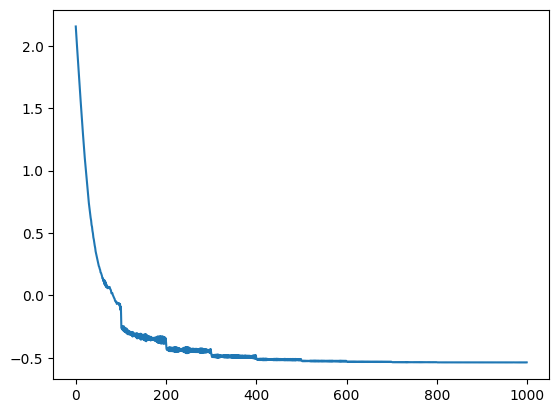

In [16]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [17]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x2)[0]).detach().squeeze()
BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss

BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(2.0189)

tensor(0.0885)

tensor(0.0076)

tensor(1.9229)

In [18]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[90,  0],
       [ 1, 69]])

array([[88,  0],
       [ 0, 72]])

array([[68,  1],
       [ 1, 90]])

In [28]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta = config["lambda1"], config["lambda2"],config["eta"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.7
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
#         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, targets_1[idx_test].reshape(-1,1))

        test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "eta": tune.choice([0.06,0.08,0.09,0.1,0.11,0.12,0.2])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=100)
    
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2
train_model_bfa69_00000,RUNNING,10.224.0.12:19232,0.06,0.02,0.003
train_model_bfa69_00001,RUNNING,10.224.0.12:19716,0.12,0.04,0.001
train_model_bfa69_00002,RUNNING,10.224.0.12:19718,0.12,0.01,0.003
train_model_bfa69_00003,RUNNING,10.224.0.12:19720,0.1,0.02,0.003
train_model_bfa69_00004,RUNNING,10.224.0.12:19722,0.2,0.04,0.003
train_model_bfa69_00005,RUNNING,10.224.0.12:19724,0.12,0.01,0.001
train_model_bfa69_00006,RUNNING,10.224.0.12:19726,0.11,0.05,0.001
train_model_bfa69_00007,RUNNING,10.224.0.12:19728,0.09,0.04,0.003
train_model_bfa69_00008,RUNNING,10.224.0.12:19730,0.09,0.05,0.002
train_model_bfa69_00009,RUNNING,10.224.0.12:19732,0.2,0.04,0.001


2022-10-12 15:52:30,601	WARNING tune.py:686 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2022-10-12 15:52:37,385	ERROR tune.py:754 -- Trials did not complete: [train_model_bfa69_00000, train_model_bfa69_00001, train_model_bfa69_00002, train_model_bfa69_00003, train_model_bfa69_00004, train_model_bfa69_00005, train_model_bfa69_00006, train_model_bfa69_00007, train_model_bfa69_00008, train_model_bfa69_00009, train_model_bfa69_00010, train_model_bfa69_00011, train_model_bfa69_00012, train_model_bfa69_00013, train_model_bfa69_00014, train_model_bfa69_00015, train_model_bfa69_00016, train_model_bfa69_00017, train_model_bfa69_00018, train_model_bfa69_00019, train_model_bfa69_00020, train_model_bfa69_00021, train_model_bfa69_00022, train_model_bfa69_00023, train_model_bfa69_00024, train_model_bfa69_00025, train_model_bfa69_00026, train_model_bfa69_0

======================== Result =========================
                                experiment_id                 date  \
trial_id                                                             
bfa69_00000  576da5a5e5894a41b800f0a237eff6b6  2022-10-12_15-52-01   
bfa69_00001  d0ebf64ca0554d1783b09afc6aeaeef5  2022-10-12_15-52-04   
bfa69_00002  def4246864344fc8818fa04598a5bea4  2022-10-12_15-52-05   
bfa69_00003  e7e94b4f5e6e4a7c8168c5b0b727b5da  2022-10-12_15-52-04   
bfa69_00004  b65df09a233741128f209747909e166b  2022-10-12_15-52-04   
...                                       ...                  ...   
bfa69_00062                               NaN                  NaN   
bfa69_00063                               NaN                  NaN   
bfa69_00064                               NaN                  NaN   
bfa69_00065                               NaN                  NaN   
bfa69_00066                               NaN                  NaN   

                timestamp      

In [22]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
final_parameter

Best trial final validation loss: 1.134885013103485


{'lambda1': 0.05, 'lambda2': 0.003, 'eta': 0.09}

In [23]:
################## second step##################

#no prior
prior=0

#0.4,0.4
# set hyperparamters
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2,eta=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"]
learning_rate=0.7
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.3800, grad_fn=<AddBackward0>)

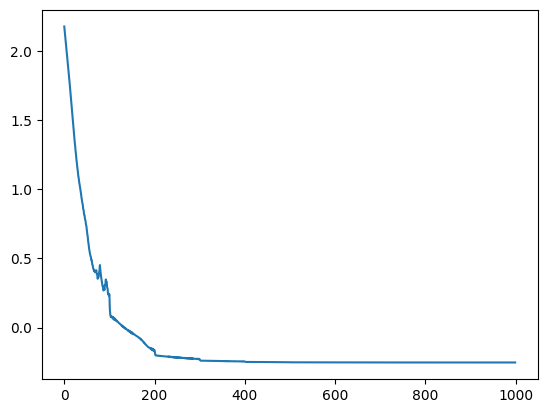

In [24]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [25]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.3098e-01, -1.7866e-01, -2.3821e-01, -1.3302e-01, -2.2257e-01,
         -2.2269e-01, -1.5741e-01, -1.4293e-01, -2.0345e-01,  1.7701e-01,
         -1.6852e-06, -1.5882e-06,  2.4899e-06,  2.7718e-03, -3.0317e-07,
         -4.8538e-07, -2.7519e-06,  7.9956e-07, -3.9305e-07,  1.5427e-06,
         -7.8524e-07, -1.6218e-06, -2.4739e-07, -7.7205e-07,  1.5087e-06,
          2.3343e-07, -2.2690e-06,  1.4120e-06, -1.9681e-06, -1.8171e-07,
         -7.5957e-07, -4.0095e-07,  5.7470e-07,  5.8130e-07,  1.6709e-06,
          1.4103e-06,  1.6855e-07, -2.3584e-07, -1.9882e-06, -2.5133e-06,
         -4.1489e-07,  1.9262e-06,  1.6831e-07,  1.5809e-06,  2.0257e-06,
         -2.1603e-06, -1.9334e-06, -2.7293e-06, -2.1966e-06,  1.8662e-08,
          5.4522e-07,  1.4648e-07, -4.0074e-07, -9.3801e-07, -1.6753e-06,
          3.6389e-06,  1.5100e-06,  1.8302e-06,  3.0092e-06,  5.4053e-07,
          1.2584e-07,  1.3083e-06, -8.3890e-05, -2.8803e-06, -4.2998e-07,
         -9.2576e-07,  5.7746e-08,  5.

tensor([[-1.3098e-01, -1.7866e-01, -2.3821e-01, -1.3302e-01, -2.2257e-01,
         -2.2269e-01, -1.5741e-01, -1.4293e-01, -2.0345e-01,  1.7701e-01,
         -1.6852e-06, -1.5882e-06,  2.4899e-06,  2.7718e-03, -3.0317e-07,
         -4.8538e-07, -2.7519e-06,  7.9956e-07, -3.9305e-07,  1.5427e-06,
         -7.8524e-07, -1.6218e-06, -2.4739e-07, -7.7205e-07,  1.5087e-06,
          2.3343e-07, -2.2690e-06,  1.4120e-06, -1.9681e-06, -1.8171e-07,
         -7.5957e-07, -4.0095e-07,  5.7470e-07,  5.8130e-07,  1.6709e-06,
          1.4103e-06,  1.6855e-07, -2.3584e-07, -1.9882e-06, -2.5133e-06,
         -4.1489e-07,  1.9262e-06,  1.6831e-07,  1.5809e-06,  2.0257e-06,
         -2.1603e-06, -1.9334e-06, -2.7293e-06, -2.1966e-06,  1.8662e-08,
          5.4522e-07,  1.4648e-07, -4.0074e-07, -9.3801e-07, -1.6753e-06,
          3.6389e-06,  1.5100e-06,  1.8302e-06,  3.0092e-06,  5.4053e-07,
          1.2584e-07,  1.3083e-06, -8.3890e-05, -2.8803e-06, -4.2998e-07,
         -9.2576e-07,  5.7746e-08,  5.

tensor([[-1.5832e-01, -2.1743e-01, -2.5995e-01, -1.8500e-01,  2.1513e-01,
         -2.7355e-01, -1.8009e-01, -1.5872e-01, -2.0032e-01, -2.3936e-01,
         -5.8420e-07,  8.0542e-08, -8.2419e-09,  3.9491e-02,  4.8546e-08,
         -2.9609e-09, -3.7507e-07,  3.7163e-07,  1.7599e-07, -3.9572e-08,
          6.7629e-09,  2.6201e-07, -5.7135e-08, -2.8092e-07,  1.1539e-06,
          2.2795e-08,  4.9151e-07, -6.2786e-07,  1.9375e-07,  4.0162e-08,
         -3.1855e-08,  9.0721e-08,  7.7689e-08,  4.2380e-07,  5.3505e-07,
          7.0514e-08, -1.8684e-08,  2.2079e-09,  2.8699e-09, -8.6294e-08,
          2.3338e-07,  1.4941e-07, -1.1978e-08,  1.5130e-06, -2.7904e-08,
         -6.9384e-08, -1.6208e-06, -7.6323e-08,  8.8143e-08, -1.3975e-08,
         -1.3919e-08, -9.1863e-08, -2.9940e-07,  2.3032e-07,  4.2469e-08,
         -5.1145e-07,  1.0783e-06,  3.8894e-07, -1.1051e-07, -1.1457e-07,
         -2.6175e-07,  2.8118e-08, -3.8797e-03, -4.9505e-07,  6.4576e-08,
         -1.1212e-07,  7.2089e-08,  2.

In [26]:

model_1(test_x1)[0].squeeze()
model_2(test_x2)[0].squeeze()
model_3(test_x3)[0].squeeze()


tensor([9.7494e-01, 9.7690e-01, 1.7812e-01, 6.2954e-01, 1.5455e-03, 9.7514e-01,
        9.2838e-01, 5.8910e-02, 9.7177e-01, 8.2028e-01, 1.1353e-05, 9.7216e-01,
        9.8093e-01, 1.5818e-02, 4.7888e-01, 9.5800e-01, 9.2891e-02, 9.1850e-01,
        1.6788e-02, 6.4649e-03, 3.7814e-03, 9.6626e-01, 9.4953e-01, 4.7289e-01,
        7.2071e-01, 2.5695e-01, 2.0491e-01, 2.3160e-02, 5.3245e-01, 3.1807e-01,
        1.6732e-01, 1.7181e-01, 1.4874e-03, 4.9758e-01, 1.4131e-01, 7.9057e-01,
        9.2064e-01, 9.3912e-01, 2.8301e-01, 8.5550e-04],
       grad_fn=<SqueezeBackward0>)

tensor([1.2113e-01, 9.9643e-01, 3.0562e-02, 8.9261e-01, 8.3461e-01, 9.9319e-01,
        9.8623e-01, 9.9189e-01, 1.2734e-02, 8.8128e-01, 7.3375e-01, 9.9112e-01,
        7.7170e-07, 9.9739e-01, 1.0081e-01, 5.2771e-03, 9.9762e-01, 9.8445e-01,
        2.5383e-02, 9.4058e-01, 1.4334e-01, 2.0557e-01, 2.6939e-03, 4.0745e-07,
        8.2485e-01, 7.1783e-04, 1.5039e-01, 3.5666e-03, 2.0375e-01, 8.5122e-01,
        8.1863e-01, 5.8080e-02, 2.1005e-06, 1.0942e-01, 8.6390e-01, 9.9897e-01,
        9.7328e-01, 3.6492e-03, 9.9183e-01, 8.3364e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0.4355, 0.9525, 0.9454, 0.9462, 0.0344, 0.2753, 0.6699, 0.2305, 0.9462,
        0.8775, 0.8921, 0.0692, 0.9589, 0.4387, 0.9567, 0.1591, 0.9578, 0.9420,
        0.8953, 0.9569, 0.7278, 0.5315, 0.8102, 0.8216, 0.1767, 0.0224, 0.0160,
        0.9528, 0.5824, 0.9459, 0.7505, 0.0068, 0.8647, 0.9086, 0.0242, 0.1044,
        0.3924, 0.7791, 0.4845, 0.1506], grad_fn=<SqueezeBackward0>)

In [27]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[44,  7],
       [13, 56]])

0.8115942028985508

0.8627450980392157

0.8333333333333334

0.8888888888888888

0.8484848484848485

In [61]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[18,  0],
       [ 5, 17]])

0.7727272727272727

1.0

array([[11,  4],
       [ 8, 17]])

0.68

0.7333333333333333

array([[15,  3],
       [ 1, 21]])

0.9545454545454546

0.8333333333333334

In [17]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.6807148e-01, -1.6523018e-01, -2.4909693e-01, -1.3623613e-01,
        -2.5329618e-06, -2.6719573e-01, -1.5270296e-01, -1.7081627e-01,
         3.5446288e-08, -1.7947702e-01,  1.7094713e-06,  1.3579272e-06,
        -2.2179115e-07,  1.2566192e-06,  1.5161080e-06,  4.0506143e-07,
        -1.5321531e-06, -2.3324267e-06, -1.6800984e-06, -5.7609515e-07,
         2.2060633e-06, -1.8009963e-06, -6.8497809e-07,  2.3328000e-06,
         1.5483516e-06, -2.7790447e-06, -1.3028015e-06,  1.3451755e-06,
         2.2694037e-06,  1.3462188e-06,  3.6921145e-07,  6.9366291e-07,
         2.2278546e-06,  1.8966003e-06,  2.2355669e-06,  2.4525727e-06,
        -3.4397823e-07, -1.7066709e-06, -5.2133271e-07, -1.5838939e-06,
         1.0658036e-06,  1.8548850e-06, -1.1017735e-06,  1.3515918e-06,
        -4.6247155e-07, -1.1770998e-06, -1.6253075e-06,  3.5349606e-07,
        -9.5824021e-07,  6.3917986e-07, -2.6546852e-06,  5.3024633e-07,
        -1.3671590e-06, -1.4709882e-07,  7.7953047e-07,  3.42767

array([[-1.6807148e-01, -1.6523018e-01, -2.4909693e-01, -1.3623613e-01,
        -2.5329618e-06, -2.6719573e-01, -1.5270296e-01, -1.7081627e-01,
         3.5446288e-08, -1.7947702e-01,  1.7094713e-06,  1.3579272e-06,
        -2.2179115e-07,  1.2566192e-06,  1.5161080e-06,  4.0506143e-07,
        -1.5321531e-06, -2.3324267e-06, -1.6800984e-06, -5.7609515e-07,
         2.2060633e-06, -1.8009963e-06, -6.8497809e-07,  2.3328000e-06,
         1.5483516e-06, -2.7790447e-06, -1.3028015e-06,  1.3451755e-06,
         2.2694037e-06,  1.3462188e-06,  3.6921145e-07,  6.9366291e-07,
         2.2278546e-06,  1.8966003e-06,  2.2355669e-06,  2.4525727e-06,
        -3.4397823e-07, -1.7066709e-06, -5.2133271e-07, -1.5838939e-06,
         1.0658036e-06,  1.8548850e-06, -1.1017735e-06,  1.3515918e-06,
        -4.6247155e-07, -1.1770998e-06, -1.6253075e-06,  3.5349606e-07,
        -9.5824021e-07,  6.3917986e-07, -2.6546852e-06,  5.3024633e-07,
        -1.3671590e-06, -1.4709882e-07,  7.7953047e-07,  3.42767

array([[-1.6807148e-01, -1.6523018e-01, -2.4909693e-01, -1.3623613e-01,
        -2.5329618e-06, -2.6719573e-01, -1.5270296e-01, -1.7081627e-01,
         3.5446288e-08, -1.7947702e-01,  1.7094713e-06,  1.3579272e-06,
        -2.2179115e-07,  1.2566192e-06,  1.5161080e-06,  4.0506143e-07,
        -1.5321531e-06, -2.3324267e-06, -1.6800984e-06, -5.7609515e-07,
         2.2060633e-06, -1.8009963e-06, -6.8497809e-07,  2.3328000e-06,
         1.5483516e-06, -2.7790447e-06, -1.3028015e-06,  1.3451755e-06,
         2.2694037e-06,  1.3462188e-06,  3.6921145e-07,  6.9366291e-07,
         2.2278546e-06,  1.8966003e-06,  2.2355669e-06,  2.4525727e-06,
        -3.4397823e-07, -1.7066709e-06, -5.2133271e-07, -1.5838939e-06,
         1.0658036e-06,  1.8548850e-06, -1.1017735e-06,  1.3515918e-06,
        -4.6247155e-07, -1.1770998e-06, -1.6253075e-06,  3.5349606e-07,
        -9.5824021e-07,  6.3917986e-07, -2.6546852e-06,  5.3024633e-07,
        -1.3671590e-06, -1.4709882e-07,  7.7953047e-07,  3.42767

In [18]:
threshold=0.15
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.16807148, -0.16523018, -0.24909693, -0.13623613,  0.        ,
        -0.26719573, -0.15270296, -0.17081627,  0.        , -0.17947702,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  6,  7,  8, 10])

8

(raylet) [2022-10-01 00:23:50,618 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 734851072; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:24:00,624 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 734756864; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:24:10,630 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 734621696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:24:20,636 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 734486528; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 00:29:00,965 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 722259968; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:29:10,994 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 721575936; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:29:21,016 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 720920576; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:29:31,023 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 720027648; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 00:34:11,242 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 711323648; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:34:21,271 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 710606848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:34:31,294 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 709640192; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:34:41,313 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 709021696; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 00:39:21,475 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 704974848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:39:31,480 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 704811008; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:39:41,485 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 704688128; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:39:51,491 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 704565248; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 00:44:31,663 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 701014016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:44:41,670 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 700874752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:44:51,677 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 700760064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:45:01,683 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 700596224; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 00:49:41,855 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 697081856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:49:51,861 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 696971264; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:50:01,867 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 696819712; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:50:11,872 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 696705024; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 00:54:52,043 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 693178368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:55:02,048 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 693022720; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:55:12,053 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 692899840; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 00:55:22,059 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 692760576; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:00:02,235 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 689152000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:00:12,242 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 689033216; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:00:22,248 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 688922624; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:00:32,256 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 688803840; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:05:12,445 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 685223936; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:05:22,452 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 685092864; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:05:32,458 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 684990464; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:05:42,465 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 684859392; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:10:22,650 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 681254912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:10:32,655 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 681107456; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:10:42,663 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 681005056; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:10:52,669 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 680886272; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:15:32,863 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 677261312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:15:42,869 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 677158912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:15:52,876 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 677023744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:16:02,883 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 676917248; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:20:43,071 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 673361920; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:20:53,078 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 673251328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:21:03,085 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 673140736; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:21:13,092 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 673005568; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:25:53,281 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 669425664; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:26:03,287 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 669327360; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:26:13,294 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 669184000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:26:23,301 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 669036544; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:31:03,487 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 665505792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:31:13,494 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 665374720; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:31:23,499 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 665239552; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:31:33,505 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 665079808; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:36:13,695 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 661426176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:36:23,703 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 661311488; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:36:33,710 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 661127168; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:36:43,717 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 661032960; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:41:23,911 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 657457152; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:41:33,918 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 657285120; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:41:43,925 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 657170432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:41:53,933 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 657051648; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:46:34,121 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 653459456; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:46:44,128 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 653332480; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:46:54,135 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 653225984; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:47:04,142 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 653078528; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:51:44,333 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 649469952; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:51:54,339 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 649383936; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:52:04,346 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 649232384; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:52:14,353 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 649076736; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 01:56:54,539 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 645500928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:57:04,546 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 645345280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:57:14,553 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 645214208; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 01:57:24,560 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 645087232; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:02:04,750 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 641458176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:02:14,757 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 641302528; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:02:24,764 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 641216512; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:02:34,771 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 641044480; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:07:14,956 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 637440000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:07:24,963 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 637304832; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:07:34,970 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 637173760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:07:44,976 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 637054976; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:12:25,168 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 633417728; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:12:35,175 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 633270272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:12:45,182 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 633114624; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:12:55,189 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 633024512; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:17:35,371 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 629399552; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:17:45,377 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 629297152; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:17:55,384 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 629178368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:18:05,391 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 629063680; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:22:45,581 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 625487872; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:22:55,588 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 625405952; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:23:05,595 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 625299456; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:23:15,601 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 625115136; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:27:55,815 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 621608960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:28:05,823 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 621490176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:28:15,829 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 621318144; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:28:25,836 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 621215744; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:33:06,052 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 617586688; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:33:16,059 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 617406464; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:33:26,066 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 617320448; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:33:36,073 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 617185280; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:38:16,268 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 613425152; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:38:26,274 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 613318656; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:38:36,281 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 613150720; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:38:46,287 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 613040128; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:43:26,468 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 609386496; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:43:36,474 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 609251328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:43:46,481 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 609087488; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:43:56,488 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 609013760; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:48:36,674 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 605208576; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:48:46,681 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 605069312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:48:56,688 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 604987392; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:49:06,694 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 604782592; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 02:55:36,994 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 599347200; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:55:47,001 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 599191552; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:55:57,007 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 599109632; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 02:56:07,015 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 598970368; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:00:47,205 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 595017728; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:00:57,212 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 594915328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:01:07,217 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 594767872; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:01:17,224 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 594563072; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:05:57,404 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 590696448; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:06:07,410 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 590548992; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:06:17,417 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 590344192; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:06:27,423 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 590217216; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:11:07,602 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 586330112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:11:17,608 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 586121216; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:11:27,614 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 585986048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:11:37,620 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 585797632; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:16:17,806 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 581906432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:16:27,812 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 581763072; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:16:37,819 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 581619712; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:16:47,826 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 581472256; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:21:28,010 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 577540096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:21:38,017 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 577388544; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:21:48,023 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 577241088; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:21:58,029 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 577179648; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:26:38,231 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 573222912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:26:48,239 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 573079552; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:26:58,246 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 572981248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:27:08,252 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 572870656; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:31:48,428 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 568897536; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:31:58,434 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 568795136; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:32:08,441 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 568664064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:32:18,448 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 568516608; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:36:58,727 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 564584448; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:37:08,734 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 564461568; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:37:18,740 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 564301824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:37:28,746 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 564166656; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:42:08,933 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 560230400; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:42:18,940 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 560099328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:42:28,946 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 559972352; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:42:38,953 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 559808512; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:47:19,141 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 555900928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:47:29,148 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 555769856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:47:39,154 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 555610112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:47:49,161 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 555499520; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:52:29,395 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 551550976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:52:39,399 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 551399424; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:52:49,404 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 551276544; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:52:59,410 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 551161856; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 03:57:39,599 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 547196928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:57:49,606 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 547061760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:57:59,612 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 546938880; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 03:58:09,620 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 546811904; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:02:49,807 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 542846976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:02:59,814 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 542756864; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:03:09,821 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 542609408; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:03:19,827 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 542400512; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:08:00,015 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 538554368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:08:10,022 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 538427392; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:08:20,028 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 538259456; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:08:30,035 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 538095616; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:13:10,220 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 534208512; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:13:20,226 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 534036480; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:13:30,233 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 533889024; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:13:40,239 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 533745664; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:18:20,430 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 529846272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:18:30,437 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 529682432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:18:40,444 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 529522688; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:18:50,451 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 529391616; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:23:30,638 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 525475840; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:23:40,645 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 525332480; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:23:50,652 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 525193216; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:24:00,658 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 525090816; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:28:40,839 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 521134080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:28:50,845 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 521007104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:29:00,851 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 520892416; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:29:10,858 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 520765440; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:33:51,037 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 516808704; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:34:01,044 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 516694016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:34:11,052 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 516554752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:34:21,058 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 516431872; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:39:01,244 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 512458752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:39:11,251 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 512344064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:39:21,258 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 512212992; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:39:31,265 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 512065536; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:44:11,455 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 508162048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:44:21,462 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 508018688; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:44:31,468 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 507858944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:44:41,475 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 507711488; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:49:21,668 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 503812096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:49:31,676 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 503664640; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:49:41,682 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 503521280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:49:51,690 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 503386112; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:54:31,881 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 499449856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:54:41,887 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 499294208; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:54:51,894 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 499171328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:55:01,901 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 499015680; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 04:59:42,098 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 495120384; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 04:59:52,104 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 494997504; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:00:02,111 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 494837760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:00:12,117 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 494673920; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:04:52,306 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 490786816; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:05:02,312 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 490631168; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:05:12,317 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 490475520; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:05:22,324 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 490344448; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:10:02,577 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 486432768; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:10:12,584 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 486268928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:10:22,591 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 486137856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:10:32,597 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 485998592; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:15:12,811 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 482058240; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:15:22,817 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 481927168; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:15:32,824 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 481783808; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:15:42,831 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 481665024; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:20:23,019 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 477704192; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:20:33,025 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 477577216; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:20:43,032 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 477429760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:20:53,039 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 477310976; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:25:33,229 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 473387008; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:25:43,287 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 473247744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:25:53,293 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 473133056; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:26:03,300 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 472985600; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:30:43,487 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 469049344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:30:53,494 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 468914176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:31:03,500 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 468783104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:31:13,507 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 468656128; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:35:53,696 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 464855040; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:36:03,703 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 464740352; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:36:13,710 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 464609280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:36:23,717 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 464494592; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:41:03,901 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 460636160; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:41:13,908 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 460496896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:41:23,915 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 460369920; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:41:33,922 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 460161024; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:46:14,113 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 456302592; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:46:24,119 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 456159232; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:46:34,125 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 455979008; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:46:44,132 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 455860224; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:51:24,316 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 451952640; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:51:34,323 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 451772416; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:51:44,329 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 451665920; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:51:54,335 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 451526656; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 05:56:34,544 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 447565824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:56:44,551 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 447451136; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:56:54,557 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 447328256; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 05:57:04,563 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 447164416; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:01:44,756 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 443244544; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:01:54,764 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 443113472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:02:04,770 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 442970112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:02:14,778 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 442798080; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:06:54,963 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 438923264; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:07:04,970 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 438775808; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:07:14,977 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 438575104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:07:24,983 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 438468608; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:12:05,175 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 434589696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:12:15,181 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 434401280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:12:25,188 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 434290688; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:12:35,195 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 434106368; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:17:15,376 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 430166016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:17:25,383 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 430051328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:17:35,390 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 429912064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:17:45,396 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 429760512; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:22:25,599 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 425861120; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:22:35,605 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 425709568; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:22:45,611 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 425570304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:22:55,618 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 425480192; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:27:35,797 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 421498880; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:27:45,803 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 421367808; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:27:55,810 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 421265408; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:28:05,817 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 421130240; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:32:46,003 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 417153024; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:32:56,008 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 417046528; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:33:06,015 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 416927744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:33:16,022 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 416751616; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:37:56,225 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 412868608; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:38:06,232 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 412745728; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:38:16,238 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 412577792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:38:26,245 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 412459008; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:43:06,429 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 408539136; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:43:16,436 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 408371200; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:43:26,443 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 408248320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:43:36,449 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 408068096; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:48:16,633 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 404160512; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:48:26,639 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 404066304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:48:36,646 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 403865600; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:48:46,653 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 403738624; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:53:26,871 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 399867904; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:53:36,878 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 399679488; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:53:46,885 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 399536128; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:53:56,892 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 399429632; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 06:58:37,083 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 395472896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:58:47,090 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 395329536; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:58:57,097 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 395231232; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 06:59:07,103 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 395096064; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:03:47,295 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 391118848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:03:57,302 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 391020544; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:04:07,309 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 390881280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:04:17,316 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 390692864; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:08:57,501 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 386826240; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:09:07,508 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 386678784; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:09:17,515 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 386486272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:09:27,521 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 386383872; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:14:07,709 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 382484480; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:14:17,716 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 382275584; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:14:27,723 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 382160896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:14:37,730 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 382001152; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:19:17,952 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 378093568; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:19:27,958 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 377958400; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:19:37,965 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 377810944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:19:47,972 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 377651200; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:24:28,156 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 373727232; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:24:38,162 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 373579776; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:24:48,169 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 373444608; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:24:58,175 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 373334016; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:29:38,352 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 369393664; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:29:48,359 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 369254400; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:29:58,365 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 369152000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:30:08,372 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 369020928; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:34:48,557 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 365051904; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:34:58,564 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 364969984; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:35:08,571 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 364896256; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:35:18,579 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 364748800; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:39:58,771 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 361095168; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:40:08,777 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 360960000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:40:18,784 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 360792064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:40:28,791 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 360644608; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:45:08,979 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 356749312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:45:18,986 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 356601856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:45:29,015 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 356454400; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:45:39,022 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 356311040; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:50:19,208 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 352382976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:50:29,215 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 352260096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:50:39,222 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 352100352; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:50:49,229 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 351965184; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 07:55:29,407 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 348045312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:55:39,414 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 347881472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:55:49,419 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 347762688; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 07:55:59,425 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 347639808; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:00:39,590 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 343707648; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:00:49,596 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 343568384; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:00:59,601 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 343437312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:01:09,607 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 343326720; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:05:49,785 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 339386368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:05:59,791 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 339251200; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:06:09,798 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 339128320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:06:19,804 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 338939904; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:10:59,989 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 335036416; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:11:09,996 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 334913536; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:11:20,002 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 334716928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:11:30,009 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 334561280; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:16:10,195 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 330715136; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:16:20,202 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 330530816; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:16:30,209 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 330362880; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:16:40,215 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 330219520; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:21:20,404 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 326320128; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:21:30,412 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 326168576; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:21:40,418 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 326004736; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:21:50,423 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 325877760; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:26:30,701 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 321974272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:26:40,708 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 321818624; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:26:50,714 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 321703936; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:27:00,721 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 321585152; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:31:40,903 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 317616128; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:31:50,910 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 317493248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:32:00,917 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 317370368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:32:10,923 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 317255680; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:36:51,113 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 313278464; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:37:01,119 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 313167872; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:37:11,125 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 313044992; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:37:21,131 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 312877056; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:42:01,351 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 308985856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:42:11,358 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 308867072; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:42:21,365 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 308690944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:42:31,371 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 308543488; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:47:11,551 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 304607232; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:47:21,557 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 304476160; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:47:31,564 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 304332800; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:47:41,571 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 304185344; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:52:21,755 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 300294144; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:52:31,768 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 300158976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:52:41,828 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 300011520; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:52:51,864 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 299913216; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 08:57:32,067 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 295915520; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:57:42,072 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 295792640; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:57:52,078 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 295657472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 08:58:02,083 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 295534592; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:02:42,263 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 291598336; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:02:52,269 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 291463168; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:03:02,276 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 291328000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:03:12,283 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 291176448; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:07:52,463 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 287285248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:08:02,470 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 287141888; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:08:12,477 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 286986240; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:08:22,484 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 286834688; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:13:02,669 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 282931200; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:13:12,676 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 282759168; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:13:22,682 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 282632192; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:13:32,689 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 282464256; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:18:12,881 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 278540288; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:18:22,886 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 278409216; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:18:32,892 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 278261760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:18:42,898 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 278122496; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:23:23,114 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 274206720; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:23:33,120 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 274055168; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:23:43,127 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 273895424; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:23:53,134 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 273776640; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:28:33,320 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 269856768; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:28:43,328 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 269717504; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:28:53,335 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 269594624; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:29:03,342 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 269455360; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:33:43,633 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 265515008; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:33:53,672 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 265396224; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:34:03,719 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 265256960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:34:13,726 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 265109504; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:38:53,912 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 261189632; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:39:03,919 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 261042176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:39:13,926 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 260919296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:39:23,932 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 260767744; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:44:04,121 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 256823296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:44:14,128 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 256700416; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:44:24,134 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 256569344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:44:34,141 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 256380928; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:49:14,327 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 252514304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:49:24,333 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 252375040; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:49:34,339 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 252198912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:49:44,346 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 252092416; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:54:24,532 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 248147968; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:54:34,540 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 247975936; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:54:44,546 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 247865344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:54:54,553 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 247742464; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 09:59:34,742 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 243773440; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:59:44,749 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 243646464; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 09:59:54,756 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 243523584; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:00:04,763 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 243380224; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 10:04:44,994 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 239472640; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:04:55,001 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 239337472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:05:05,007 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 239190016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:05:15,013 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 238997504; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 10:09:55,188 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 235122688; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:10:05,194 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 234975232; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:10:15,200 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 234807296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:10:25,207 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 234663936; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 10:15:05,446 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 230797312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:15:15,453 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 230617088; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:15:25,460 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 230494208; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:15:35,467 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 230313984; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 10:20:15,694 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 226394112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:20:25,701 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 226267136; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:20:35,707 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 226103296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:20:45,713 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 225955840; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 10:25:25,884 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 222097408; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:25:35,890 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 221904896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:25:45,896 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 221782016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:25:55,903 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 221659136; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-01 10:30:36,074 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 217677824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:30:46,081 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 217559040; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:30:56,087 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 217444352; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-01 10:31:06,092 E 7151 7169] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-01_00-19-58_494014_7026 is over 95% full, available space: 217313280; capacity: 29394726912. Object creation will fail if spilling i